In [1]:
# MEMORY CLEAN
# import gc
# gc.collect()
from IPython import get_ipython
get_ipython().run_line_magic('reset',  '-sf')

In [2]:
# IMPORT
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error

In [ ]:
# DATA WRANGLER
# Replace path with your own existing local path, accessed from the OpenBiomechanics GitHub Repository
path1 = os.path.join("openbiomechanics", "baseball_pitching", "data", "metadata.csv")
meta_data = pd.read_csv(path1)
path2 = os.path.join("openbiomechanics", "baseball_pitching", "data", "full_sig", "forces_moments.csv")
data = pd.read_csv(path2)
path3 = os.path.join("openbiomechanics", "baseball_pitching", "data", "full_sig", "force_plate.csv")
force_data = pd.read_csv(path3)
path4 = os.path.join("openbiomechanics", "baseball_pitching", "data", "poi", "poi_metrics.csv")
poi = pd.read_csv(path4)

# data.groupby('session_pitch').count()
# force_data.groupby('session_pitch').count()
# meta_data.groupby('session_pitch').count()

# Filter by pitch speed, sort by ID num
meta_data = meta_data[meta_data.pitch_speed_mph >= 89].sort_values(by=['session_pitch'], ascending=True)
meta_data['session_pitch'] = meta_data['session_pitch'].str.replace('_', '.', regex=False)
poi['session_pitch'] = poi['session_pitch'].str.replace('_', '.', regex=False)
# Filter session ID by first trial (..._1)
filt_meta_data = meta_data[meta_data['session_pitch'].str.endswith('1')]
constr_data = pd.merge(filt_meta_data[['session_pitch']], data, on='session_pitch', how='left')
constr_poi = pd.merge(filt_meta_data[['session_pitch']], poi, on='session_pitch', how='left')
constr_poi.drop(columns=['session', 'p_throws', 'pitch_type'], inplace=True)

In [4]:
# STATISTICS
mean_age = np.mean(filt_meta_data.age_yrs)
std_age = np.std(filt_meta_data.age_yrs)
mean_height = np.mean(filt_meta_data.session_height_m)
std_height = np.std(filt_meta_data.session_height_m)
mean_mass = np.mean(filt_meta_data.session_mass_kg)
std_mass = np.std(filt_meta_data.session_mass_kg)
# filt_meta_data['playing_level_num'] = filt_meta_data['playing_level'].replace({'college': 1, 'independent': 2, 'milb': 3})
val_counts = filt_meta_data['playing_level'].value_counts()
rel_dist = filt_meta_data['playing_level'].value_counts(normalize=True)
playing_levels = pd.DataFrame({'Playing Level': val_counts.index, 'Amount': val_counts.values, 'Relative Distribution (%)': rel_dist.values * 100})

descriptives_table = {
	'Descriptive': ['Age (years)', 'Height (m)', 'Mass (kg)'],
	'Mean': [mean_age, mean_height, mean_mass],
	'Std Dev': [std_age, std_height, std_mass]
}

# Decide Split for "injury risk" qualification (quartiles may constrain sample too much)
median = np.median(constr_poi.elbow_varus_moment)
varus = pd.DataFrame({
	'ID': constr_poi['session_pitch'],
	'varus': (constr_poi.elbow_varus_moment > median).astype(int)
})
# low_varus = constr_poi[constr_poi.elbow_varus_moment <= median]
# high_varus = constr_poi[constr_poi.elbow_varus_moment > median]

In [5]:
# CART
# Classification
# poi_train_class, poi_test_class, varus_train_class, varus_test_class = train_test_split(constr_poi, varus, test_size=0.2, random_state=42)
# clf = DecisionTreeClassifier(random_state=42)
# clf.fit(poi_train_class, varus_train_class)
# varus_pred = clf.predict(poi_test_class)
# accuracy = accuracy_score(varus_test_class, varus_pred)
# print(f"Classification accuracy: {accuracy:.2f}")

# Regression
poi_train, poi_test, varus_train, varus_test = train_test_split(constr_poi, varus, test_size=0.2, random_state=42)
reg = DecisionTreeRegressor(random_state=42)
reg.fit(poi_train, varus_train)
varus_pred = reg.predict(poi_test)
mse = mean_squared_error(varus_test, varus_pred)
print(f"Regression MSE: {mse:.2f}")
features = constr_poi.columns.tolist()
remove_features = ['session_pitch', 'pitch_speed_mph']
features = [f for f in features if f not in remove_features]

Regression MSE: 7401.80


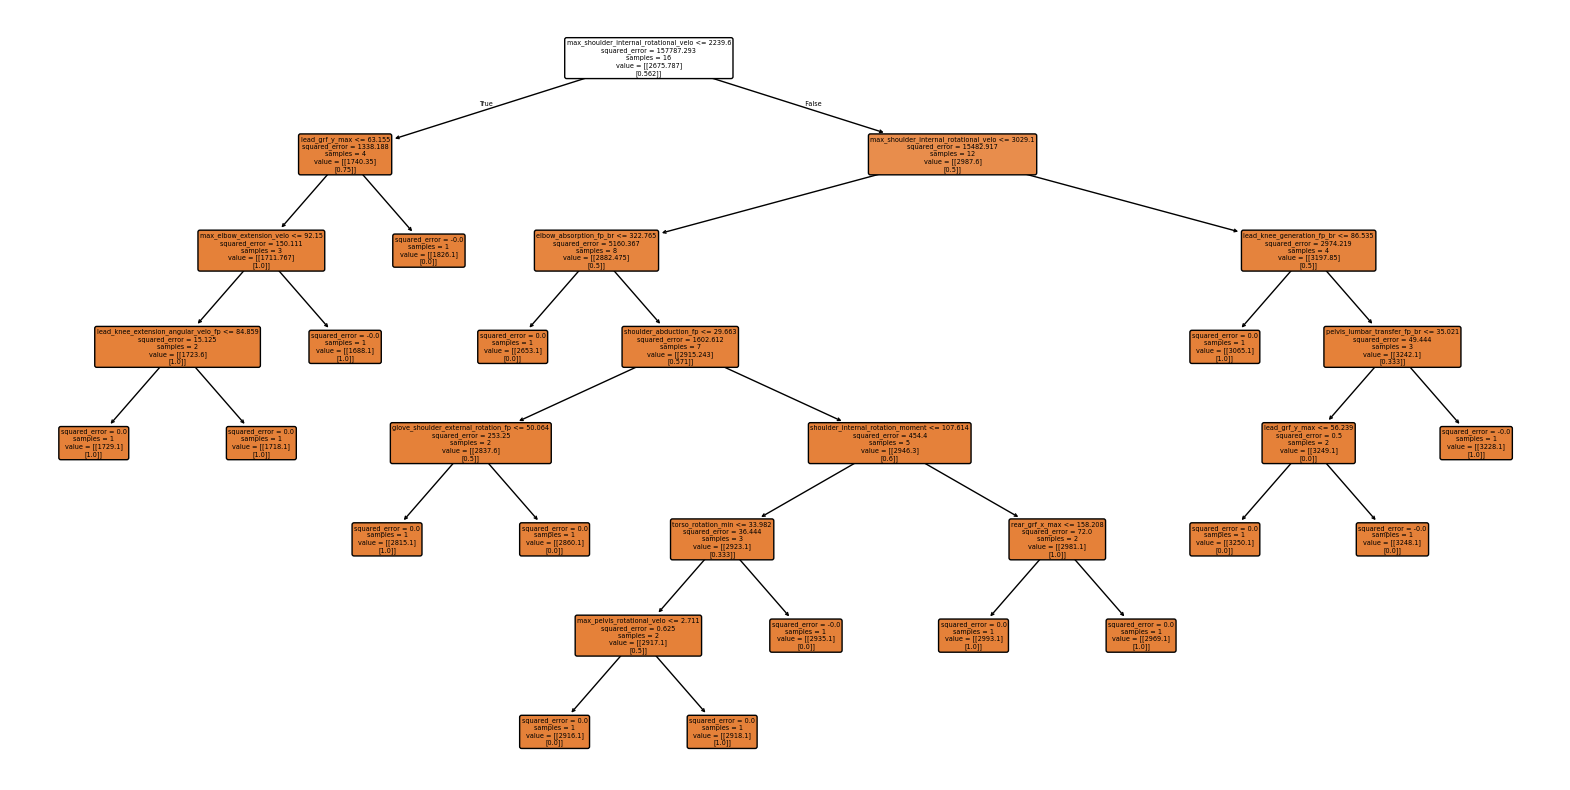

In [ ]:
# Visualize
from sklearn.tree import plot_tree

plt.figure(figsize=(40,20))
plot_tree(reg, feature_names=features, filled=True, rounded=True)
plt.show()

# Comments, first output:
# Max shoulder internal rotation velocity is the largest indicator of elbow varus torque (EVT).
# True Branch: Pitchers with lower MIR velo will have lower EVT. 
# False Branch: Pitchers with  higher MIR velo will have higher EVT.
# New model? Train based on proximal/distal influence (i.e. begin with lead knee kinematics)